# Import

In [1]:
import os
import time
import random
import re
import string
import json
import pickle
import urllib.request
import zipfile
import gzip
import shutil
import traceback
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

from bs4 import BeautifulSoup
from unidecode import unidecode
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import cleantext

from wordcloud import WordCloud
from wordcloud import STOPWORDS as wordcloud_stopwords
from PIL import Image

import gensim.downloader as gensim_api
from gensim.models import Word2Vec, KeyedVectors

import torch
from zeugma.embeddings import EmbeddingTransformer
from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, Conv1D, Flatten, Embedding, MaxPool1D,
                                     concatenate, Dropout, LSTM, Bidirectional,
                                     BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers
from tensorflow.keras.initializers import HeNormal

from transformers import (BertTokenizer, BertModel, AutoTokenizer,
                          TFAutoModelForSequenceClassification, AutoModelForSequenceClassification,
                          TextClassificationPipeline)
import keras_tuner as kt

import mlflow
from mlflow.models.signature import infer_signature

import warnings
warnings.filterwarnings("ignore", message="The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.")

if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    tf.config.optimizer.set_jit(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Autoriser l'extension progressive de la mémoire
    except RuntimeError as e:
        print(e)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

mlflow.set_tracking_uri('http://localhost:5000')
silent = True
mlflow.tensorflow.autolog(silent=silent)
mlflow.pytorch.autolog(silent=silent)
mlflow.sklearn.autolog(silent=silent)
mlflow.autolog(disable=silent)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[nltk_data] Downloading package punkt to /home/tjohanne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tjohanne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/tjohanne/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-03-01 19:26:10.578531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 19:26:10.609464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740853570.647490   83511 cuda_dnn.cc:8310] Unable to register cuDNN factory

Num GPUs Available:  1


# Preprocess data

## Load data

In [ ]:
def get_characters(string_lst):
    characters = []
    for user in string_lst:
        for c in user:
            if c not in characters:
                characters.append(c)
    characters.sort()
    return characters

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", names=["sentiment", "ids", "date", "flag", "user", "text"], encoding='latin-1')
print("nan values:")
display(df.isnull().sum())

user_characters = get_characters(df["user"])
print("user_characters:", user_characters)
text_raw_characters = get_characters(df["text"])
print("text_raw_characters:", text_raw_characters)

remove_cols = []
for col in df.columns:
    if len(df[col].unique()) < 2:
        remove_cols.append(col)
print("Removing cols:", remove_cols)
df.drop(remove_cols, axis=1, inplace=True)

display(df)
print(df["sentiment"].value_counts())

## text_preprocess
**remove:**
- html code with bs4
- accents with unidecode
- upper case
- stopwords
- punctuation
- charactères spéciaux with unidecode
- autres charactères spéciaux

**replace:**
- "\#" : "hashtag"

In [ ]:
def prepro_text(text,
                stop_words,
                remove_html=True,
                remove_accents=True,
                lower=True,
                replace_hashtag=True,
                remove_stopwords=True,
                remove_punct=True,
                remove_special_characters=True):
    if remove_html:
        text = BeautifulSoup(text).text
    if remove_accents:
        text = unidecode(text)
    if remove_html:
        text = BeautifulSoup(text).text
    if lower:
        text = text.lower()
    if replace_hashtag:
        text = text.replace("#", " hashtag ")
    if remove_punct:
        text = text.translate(str.maketrans("", "", string.punctuation))
    if remove_stopwords:
        tokens = word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stop_words]
        text = " ".join(tokens)
    if remove_special_characters:
        text = " ".join(re.sub('[^A-Za-z0-9]+', ' ', text).split())
    text = " ".join(text.split())
    return text


stop_words = nltk_stopwords.words('english')
stop_words = list(set(stop_words))
stop_words.sort()

df["text_preprocess"] = df["text"].progress_apply(prepro_text, args=(stop_words,))
text_preprocess_characters = get_characters(df["text_preprocess"])
print("text_preprocess_characters:", text_preprocess_characters)

## text_stemming

In [ ]:
ps = PorterStemmer()
def text_stemming(text, ps):
    tokens = word_tokenize(text)
    stem_tokens = [ps.stem(t) for t in tokens]
    return " ".join(stem_tokens)
df["text_stemming"] = df["text_preprocess"].progress_apply(text_stemming, args=(ps,))

## text_lemmatize

In [ ]:
lemmatizer = WordNetLemmatizer()
def text_lemmatize(text, lemmatizer):
    tokens = word_tokenize(text)
    lem_tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lem_tokens)
df["text_lemmatize"] = df["text_preprocess"].progress_apply(text_lemmatize, args=(lemmatizer,))

## Wordclouds

In [ ]:
text_cols = [c for c in df.columns if c.startswith("text")]
nb_cols = len(text_cols)
nb_rows = len(df["sentiment"].unique())
fig = plt.figure(figsize=(20, 5))
for i, col in enumerate(text_cols):
    for z, sentiment in enumerate(df["sentiment"].unique()):
        df_tmp = df[df["sentiment"] == sentiment]
        text = " ".join(df_tmp[col])
        wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=50).generate(text)
        plt.subplot(nb_rows, nb_cols, i + 1 + z * nb_cols)
        plt.title(col + " sentiment " + str(sentiment))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
plt.show()

## Save data

In [ ]:
text_cols = [c for c in df.columns if c.startswith("text")]
df[text_cols] = df[text_cols].replace("", np.nan)
display(df[text_cols].isnull().sum())

In [ ]:
display(df.tail())
df.to_csv("data.csv", index=False, encoding="utf-8")

# Model train with mlflow

Model training  
List of models used:

- LogisticRegression
- SVC
- Basic neural network
- LSTM
- phanerozoic/BERT-Sentiment-Classifier
- nlptown/bert-base-multilingual-uncased-sentiment

## Load data & utils

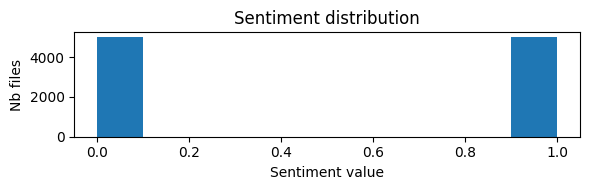

In [2]:
def log_to_mlflow(metrics=None, params=None):
    if metrics is not None:
        for k, v in metrics.items():
            if k == "confusion_matrix":
                continue
            mlflow.log_metric(k, v)
    if params is not None:
        for k, v in params.items():
            mlflow.log_param(k, v)

def get_metrics(true, pred):
    return {
        "accuracy": accuracy_score(true, pred),
        "f1": f1_score(true, pred),
        "recall": recall_score(true, pred),
        "confusion_matrix": confusion_matrix(true, pred).tolist(),
    }

df_metrics = pd.DataFrame()

def load_data(path="data.csv", nb_rows_per_sentiment=5000, verbose=False):
    df = pd.read_csv(path, encoding="utf-8")
    df = df.dropna().reset_index(drop=True)
    
    df2 = pd.DataFrame()
    for v in df["sentiment"].unique():
        df_tmp = df[df["sentiment"] == v].sample(nb_rows_per_sentiment)
        df2 = pd.concat([df2, df_tmp])
    df2.reset_index(drop=True, inplace=True)
    df = df2
    
    df["sentiment"] = df["sentiment"].replace(4, 1)

    if verbose:
        fig = plt.figure(figsize=(6, 2))
        plt.title("Sentiment distribution")
        plt.hist(df["sentiment"].values)
        plt.xlabel("Sentiment value")
        plt.ylabel("Nb files")
        plt.tight_layout()
        plt.show()
    return df

df = load_data(verbose=True)

## Modèle sur mesure simple

**List of features technique used:**  
- CountVectorizer
- TfidfVectorizer
- tensorflow Tokenizer
- Word2vec
- Glove

**List of models used:**  
- logistic regression
- svc

In [3]:
glove_model = EmbeddingTransformer('glove')

def word2vec_vectorize(w2v_model, text, vector_size=400):
    words_vecs = [w2v_model.wv[word] for word in text if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(vector_size)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def feature_process_texts(x_raw, **kwargs):
    if "ngram_range" in kwargs:
        kwargs["ngram_range"] = tuple(kwargs["ngram_range"])
    feature_process = kwargs.pop("feature_process")
    if feature_process == "CountVectorizer":
        vectorizer = CountVectorizer(**kwargs)
        X = vectorizer.fit_transform(x_raw).toarray()
    elif feature_process == "TfidfVectorizer":
        tfidf_vect = TfidfVectorizer(**kwargs)
        X = tfidf_vect.fit_transform(x_raw).toarray()
    elif feature_process == "KerasTokenizer":
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(x_raw)
        X  = tokenizer.texts_to_sequences(x_raw)
        if "max_features" in kwargs and kwargs["max_features"] is not None:
            X = pad_sequences(X, maxlen=kwargs["max_features"], padding="post")
        else:
            maxlen = max([len(x) for x in X])
            X = pad_sequences(X, maxlen=maxlen, padding="post")
        X = np.array(X)
    elif feature_process == "Word2vec":
        X = [x.split() for x in x_raw]
        # model = Word2Vec(sentences=X, **kwargs, seed=42)
        model = Word2Vec(**kwargs, seed=42)
        model.build_vocab(X)
        vector_size = model.wv.vectors[0].shape[0]
        X = np.array([word2vec_vectorize(model, x, vector_size=vector_size) for x in X])
    elif feature_process == "Glove":
        global glove_model
        X = np.array(glove_model.transform(x_raw))
    else:
        raise ValueError(f"feature_process not recognized: {feature_process}")
    return X

In [4]:
def test_skl_model(create_model_func, apply_model_func, nb_rows_per_sentiment=5000, test_size=0.3, seed=42):
    df = load_data(nb_rows_per_sentiment=nb_rows_per_sentiment)
    y = df['sentiment'].values
    text_cols = [c for c in df.columns if c.startswith("text_")]
    results = []
    for col in text_cols:
        for feature_process in ["Word2vec", "TfidfVectorizer", "KerasTokenizer", "CountVectorizer", "Glove"]:
            with mlflow.start_run() as run:
                X = feature_process_texts(df[col], feature_process=feature_process)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y, shuffle=True)
                model = create_model_func(X_train, y_train)
                y_pred = apply_model_func(model, X_test)
                metrics = get_metrics(y_test, y_pred)
                log_to_mlflow(metrics)
                mlflow.sklearn.log_model(model, artifact_path="model")
                metrics.update({"col": col, "method": feature_process})
                results.append(metrics)
    df_metrics = pd.DataFrame(results)
    df_metrics = df_metrics.sort_values(by=["f1", "accuracy", "recall"], ascending=[False, False, False]).reset_index(drop=True)
    df_metrics["date"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    df_metrics['date'] = pd.to_datetime(df_metrics['date'], format='%Y-%m-%d %H:%M:%S')
    return df_metrics

### Logistic Regression

In [5]:
def create_logistic_regression_model(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

def apply_logistic_regression_model(model, X):
    pred = model.predict(X)
    return pred

metrics = test_skl_model(create_logistic_regression_model, apply_logistic_regression_model, nb_rows_per_sentiment=5000)
metrics["model_name"] = "logistic_regression"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

🏃 View run crawling-mule-671 at: http://localhost:5000/#/experiments/0/runs/5f879f3349554c3580df177e927fa44c
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run luminous-fly-482 at: http://localhost:5000/#/experiments/0/runs/efe07d16494549da92ea8857314e57ab
🧪 View experiment at: http://localhost:5000/#/experiments/0


/home/tjohanne/miniconda3/envs/tf_test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🏃 View run charming-hog-108 at: http://localhost:5000/#/experiments/0/runs/a4d33369c5974a218b86543752962a6f
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run peaceful-cod-908 at: http://localhost:5000/#/experiments/0/runs/9ea6a60aafe140c5b51247e1b0333989
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run luxuriant-asp-342 at: http://localhost:5000/#/experiments/0/runs/4a4ae6407ed440d4a96e53c6594447cb
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run burly-lark-988 at: http://localhost:5000/#/experiments/0/runs/4d320fe4a99b43cc9eeb53fcec17898b
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run delicate-colt-907 at: http://localhost:5000/#/experiments/0/runs/4c19c135c06b4b13b4be86aee1974d0c
🧪 View experiment at: http://localhost:5000/#/experiments/0


/home/tjohanne/miniconda3/envs/tf_test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🏃 View run brawny-hen-798 at: http://localhost:5000/#/experiments/0/runs/b749c349ab6443109c99e9be0f125696
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run adventurous-flea-217 at: http://localhost:5000/#/experiments/0/runs/93e31f783c6d4e5b8a39e4b5624408c2
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run unleashed-flea-358 at: http://localhost:5000/#/experiments/0/runs/9424ed4edb69452f91c92626169f8f78
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run mercurial-owl-208 at: http://localhost:5000/#/experiments/0/runs/7d70fa8862f1473b9143528d7058b566
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run melodic-midge-765 at: http://localhost:5000/#/experiments/0/runs/4937d3b80e5e4feebdf39d93575eab3f
🧪 View experiment at: http://localhost:5000/#/experiments/0


/home/tjohanne/miniconda3/envs/tf_test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🏃 View run unruly-seal-271 at: http://localhost:5000/#/experiments/0/runs/b4c0b048242f43efbe73d829c07ff813
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run amusing-conch-433 at: http://localhost:5000/#/experiments/0/runs/31cbb9ddae5646c7ac4a1f300f39be62
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run sincere-whale-752 at: http://localhost:5000/#/experiments/0/runs/60740a6625084504bd9fe5cf52368c6b
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.741333,0.747724,0.766667,"[[1074, 426], [350, 1150]]",text_stemming,TfidfVectorizer,2025-03-01 18:28:23,logistic_regression
1,0.742333,0.747468,0.762667,"[[1083, 417], [356, 1144]]",text_lemmatize,TfidfVectorizer,2025-03-01 18:28:23,logistic_regression
2,0.741667,0.746980,0.762667,"[[1081, 419], [356, 1144]]",text_preprocess,TfidfVectorizer,2025-03-01 18:28:23,logistic_regression
3,0.730333,0.735361,0.749333,"[[1067, 433], [376, 1124]]",text_stemming,CountVectorizer,2025-03-01 18:28:23,logistic_regression
4,0.729667,0.733487,0.744000,"[[1073, 427], [384, 1116]]",text_preprocess,CountVectorizer,2025-03-01 18:28:23,logistic_regression
5,0.728000,0.732809,0.746000,"[[1065, 435], [381, 1119]]",text_lemmatize,CountVectorizer,2025-03-01 18:28:23,logistic_regression
6,0.499333,0.662320,0.982000,"[[25, 1475], [27, 1473]]",text_preprocess,KerasTokenizer,2025-03-01 18:28:23,logistic_regression
7,0.668000,0.661685,0.649333,"[[1030, 470], [526, 974]]",text_lemmatize,Glove,2025-03-01 18:28:23,logistic_regression
8,0.499000,0.661563,0.979333,"[[28, 1472], [31, 1469]]",text_lemmatize,KerasTokenizer,2025-03-01 18:28:23,logistic_regression
9,0.665000,0.661502,0.654667,"[[1013, 487], [518, 982]]",text_preprocess,Glove,2025-03-01 18:28:23,logistic_regression


### SVC

In [6]:
def create_svc_model(X, y):
    model = SVC()
    model.fit(X, y)
    return model

def apply_svc_model(model, X):
    pred = model.predict(X)
    return pred

metrics = test_skl_model(create_svc_model, apply_svc_model, nb_rows_per_sentiment=4000)
metrics["model_name"] = "svc"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

🏃 View run stately-loon-814 at: http://localhost:5000/#/experiments/0/runs/ec7670bd3f1949cba83333b65002ab00
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run luxuriant-whale-47 at: http://localhost:5000/#/experiments/0/runs/5e6cf90f0fc9441db1245c570cdc9c53
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run secretive-squid-544 at: http://localhost:5000/#/experiments/0/runs/09d99f62fc914a9d88651c0c9cda5208
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run bouncy-worm-493 at: http://localhost:5000/#/experiments/0/runs/50ae8fda47d74855959ca315895491a4
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run sassy-squid-2 at: http://localhost:5000/#/experiments/0/runs/44f81de5a8a546d688886fe8ca517ba7
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run unique-moth-521 at: http://localhost:5000/#/experiments/0/runs/19437f79fe9544f79272dc9d47df23c0
🧪 View experiment at: http://localhost:5000/#/experi

,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.872917,0.860667,0.785000,"[[1153, 47], [258, 942]]",text_preprocess,KerasTokenizer,2025-03-01 23:05:46,svc
1,0.870417,0.857011,0.776667,"[[1157, 43], [268, 932]]",text_lemmatize,KerasTokenizer,2025-03-01 23:05:46,svc
2,0.862917,0.846333,0.755000,"[[1165, 35], [294, 906]]",text_stemming,KerasTokenizer,2025-03-01 23:05:46,svc
3,0.718750,0.736431,0.785833,"[[782, 418], [257, 943]]",text_preprocess,CountVectorizer,2025-03-01 23:05:46,svc
4,0.719167,0.735893,0.782500,"[[787, 413], [261, 939]]",text_lemmatize,TfidfVectorizer,2025-03-01 23:05:46,svc
5,0.720417,0.735097,0.775833,"[[798, 402], [269, 931]]",text_stemming,TfidfVectorizer,2025-03-01 23:05:46,svc
6,0.717500,0.734326,0.780833,"[[785, 415], [263, 937]]",text_preprocess,TfidfVectorizer,2025-03-01 23:05:46,svc
7,0.714167,0.732866,0.784167,"[[773, 427], [259, 941]]",text_lemmatize,CountVectorizer,2025-03-01 23:05:46,svc
8,0.714167,0.729495,0.770833,"[[789, 411], [275, 925]]",text_stemming,CountVectorizer,2025-03-01 23:05:46,svc
9,0.686250,0.677516,0.659167,"[[856, 344], [409, 791]]",text_lemmatize,Glove,2025-03-01 23:05:46,svc


## Modèle sur mesure avancé

In [7]:
def download_glove(file_path, zip_url="http://nlp.stanford.edu/data/glove.6B.zip"):
    if not os.path.exists(file_path):
        print(f"{file_path} introuvable. Téléchargement depuis {zip_url}...")
        zip_path = "glove.6B.zip"
        urllib.request.urlretrieve(zip_url, zip_path)
        print("Extraction du fichier...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extract(file_path)
        os.remove(zip_path)
        print("Téléchargement et extraction terminés.")

def load_glove_embeddings(file_path, embedding_dim):
    if not os.path.exists(file_path):
        download_glove(file_path)
    embeddings_index = {}
    with open(file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            if len(coefs) == embedding_dim:
                embeddings_index[word] = coefs
    return embeddings_index

def load_word2vec_embeddings():
    word2vec_model = gensim_api.load("word2vec-google-news-300")
    return word2vec_model

def preprocess_input(X, max_vocab_size=20000, max_seq_length=None):
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    if max_seq_length is None:
        max_seq_length = max(len(seq) for seq in sequences)
    X_pad = pad_sequences(sequences, maxlen=max_seq_length, padding="post")
    return X_pad, tokenizer, max_seq_length

def get_embedding_layer(tokenizer, vocab_size, max_seq_length, embedding_dim=100, method="glove",
                        glove_path="glove.6B.100d.txt",
                        trainable_embedding=False):
    method = method.lower()
    if method in ["glove", "word2vec"]:
        if method == "glove":
            embeddings_index = load_glove_embeddings(glove_path, embedding_dim)
        else:
            word2vec_model = load_word2vec_embeddings()
            embedding_dim = 300
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, i in tokenizer.word_index.items():
            if i >= vocab_size:
                continue
            if method == "glove":
                embedding_vector = embeddings_index.get(word)
            else:
                try:
                    embedding_vector = word2vec_model[word]
                except KeyError:
                    embedding_vector = None
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=trainable_embedding)
    else:
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True)
    return embedding_layer

def apply_nn_model(model, X):
    sequences = model.tokenizer.texts_to_sequences(X)
    X_pad = pad_sequences(sequences, maxlen=model.max_seq_length, padding="post")
    predictions = model.predict(X_pad, verbose=0)
    return [1 if pred[0] >= 0.5 else 0 for pred in predictions]

def test_nn_model(create_model_func, apply_model_func, nb_rows_per_sentiment=5000, test_size=0.33, seed=42, **hyperparams):
    df = load_data(nb_rows_per_sentiment=nb_rows_per_sentiment)
    text_cols = [c for c in df.columns if c.startswith("text_")]
    results = []
    for col in text_cols:
        with mlflow.start_run() as run:
            X_train, X_test, y_train, y_test = train_test_split(df[col], df["sentiment"], test_size=test_size, random_state=seed, stratify=df["sentiment"])
            model = create_model_func(X_train, y_train, **hyperparams)
            y_pred = apply_model_func(model, X_test)
            metrics = get_metrics(y_test, y_pred)
            log_to_mlflow(metrics=metrics, params=hyperparams)
            mlflow.tensorflow.log_model(model, artifact_path="keras_model")
            metrics["col"] = col
            print(json.dumps(metrics, indent=4))
            metrics.update(hyperparams)
            results.append(metrics)
    df_metrics = pd.DataFrame(results)
    df_metrics = df_metrics.sort_values(by=["f1", "accuracy", "recall"], ascending=[False, False, False]).reset_index(drop=True)
    df_metrics["date"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    df_metrics['date'] = pd.to_datetime(df_metrics['date'], format='%Y-%m-%d %H:%M:%S')
    return df_metrics

### Neural network

In [8]:
def train_nn_model(X, y,
                embedding_dim=100,
                max_vocab_size=20000,
                method="glove",  # "glove", "word2vec" ou autre pour embeddings aléatoires
                glove_path="glove.6B.100d.txt",
                trainable_embedding=False,
                test_size=0.3,
                seed=42,
                epochs=100,
                batch_size=32,
                optimizer_name="adam",  # Options: "adam", "sgd", "rmsprop"
                learning_rate=0.001,
                early_stopping_patience=3,
                reduce_lr_patience=2,
                reduce_lr_factor=0.5,
                pooling_type="average",  # Options: "average" ou "max"
                hidden_units=[10],
                dense_activation="relu",
                dropout_rate=0.0,
                verbose=1):
    X_pad, tokenizer, max_seq_length = preprocess_input(X, max_vocab_size)
    vocab_size = min(max_vocab_size, len(tokenizer.word_index)) + 1
    embedding_layer = get_embedding_layer(tokenizer, vocab_size, max_seq_length,
                                          embedding_dim=embedding_dim,
                                          method=method,
                                          glove_path=glove_path,
                                          trainable_embedding=trainable_embedding)
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=test_size, stratify=y, random_state=seed)
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(embedding_layer)
    if pooling_type.lower() == "max":
        model.add(GlobalMaxPooling1D())
    else:
        model.add(GlobalAveragePooling1D())
    for units in hidden_units:
        model.add(Dense(units, activation=dense_activation))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    if optimizer_name.lower() == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("optimizer not recognized")
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=reduce_lr_patience, factor=reduce_lr_factor, verbose=0)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=verbose
    )
    for epoch, (loss, acc, val_loss, val_acc) in enumerate(zip(history.history["loss"], history.history["accuracy"], history.history["val_loss"], history.history["val_accuracy"])):
        mlflow.log_metrics({"train_loss": loss, "train_accuracy": acc, "val_loss": val_loss, "val_accuracy": val_acc}, step=epoch)

    if verbose:
        plt.figure(figsize=(10, 3))
        epochs_range = range(1, len(history.history["loss"]) + 1)
        best_epoch = np.argmin(history.history["val_loss"]) + 1
        plt.plot(epochs_range, history.history["loss"], label="Train Loss")
        plt.plot(epochs_range, history.history["val_loss"], label="Validation Loss")
        plt.axvline(best_epoch, color="red", linestyle="--", label=f"Meilleure Epoch ({best_epoch})")
        plt.title("Évolution des métriques d'entraînement")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    model.tokenizer = tokenizer
    model.max_seq_length = max_seq_length
    return model

def create_nn_model(X, y, test_size=0.3, param_grid=None, scoring='f1', seed=42, **hyperparams):
    if param_grid is None:
        param_grid = {
            "embedding_dim": [100],
            "max_vocab_size": [10000],
            "method": ["word2vec"],
            "trainable_embedding": [True],
            "epochs": [1000],
            "batch_size": [128],
            "optimizer_name": ["adam"],
            "learning_rate": [1e-4],
            "early_stopping_patience": [10],
            "reduce_lr_patience": [5],
            "reduce_lr_factor": [0.2],
            "pooling_type": ["average"],
            "hidden_units": [[10]],
            "dense_activation": ["relu"],
            "dropout_rate": [0.2]
        }
    hyperparams = {k: v if isinstance(v, list) else [v] for k, v in hyperparams.items()}
    param_grid.update(hyperparams)
    
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    if len(combinations) == 1:
        return train_nn_model(X, y, seed=seed, verbose=0, **combinations[0])
    results = []
    for cfg in tqdm(combinations):
        print("testing cfg:", cfg)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, 
            test_size=test_size, 
            stratify=y, 
            random_state=seed
        )
        model = train_nn_model(X_train, y_train, seed=seed, verbose=0, **cfg)
        y_pred = apply_nn_model(model, X_val)
        metrics = get_metrics(y_val, y_pred)
        print(json.dumps(metrics))
        metrics["cfg"] = cfg
        results.append(metrics)
    
    best_result = max(results, key=lambda x: x.get(scoring, -np.inf))
    best_cfg = best_result['cfg']
    print(f"Meilleure configuration : {best_cfg}")
    print(f"Métrique '{scoring}' : {best_result[scoring]:.3f}")
    return train_nn_model(X, y, seed=seed, verbose=0, **best_cfg)

In [9]:
metrics = test_nn_model(create_nn_model, apply_nn_model, nb_rows_per_sentiment=10000, method="glove")
metrics["model_name"] = "basic neural network"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

I0000 00:00:1740870367.573616   83511 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1740870367.578359   83511 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1740870371.917025   85572 service.cc:148] XLA service 0x7f9468003dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740870371.917670   85572 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-02 00:06:12.004917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740870372.154110   85572 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1740870373.695180   85572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
{
    "accuracy": 0.7353030303030303,
    "f1": 0.7375694757398228,
    "recall": 0.7439393939393939,
    "confusion_matrix": [
        [
            2398,
            902
        ],
        [
            845,
            2455
        ]
    ],
    "col": "text_preprocess"
}
🏃 View run tasteful-vole-627 at: http://localhost:5000/#/experiments/0/runs/8d13753b6ae3465d8034a758d0c97084
🧪 View experiment at: http://localhost:5000/#/experiments/0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
{
    "accuracy": 0.7401515151515151,
    "f1": 0.7495253395647729,
    "recall": 0.7775757575757576,
    "confusion_matrix": [
        [
            2319,
            981
        ],
        [
            734,
            2566
        ]
    ],
    "col": "text_stemming"
}
🏃 View run bald-conch-943 at: http://localhost:5000/#/experiments/0/runs/440e51548750416689c8c113c61441d2
🧪 View experiment at: http://localhost:5000/#/experiments/0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
{
    "accuracy": 0.7434848484848485,
    "f1": 0.7500369112653181,
    "recall": 0.7696969696969697,
    "confusion_matrix": [
        [
            2367,
            933
        ],
        [
            760,
            2540
        ]
    ],
    "col": "text_lemmatize"
}
🏃 View run luminous-lark-717 at: http://localhost:5000/#/experiments/0/runs/08e4392923b642f199b78e824db96cf1
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.743485,0.750037,0.769697,"[[2367, 933], [760, 2540]]",text_lemmatize,glove,2025-03-01 23:08:46,basic neural network
1,0.740152,0.749525,0.777576,"[[2319, 981], [734, 2566]]",text_stemming,glove,2025-03-01 23:08:46,basic neural network
2,0.735303,0.737569,0.743939,"[[2398, 902], [845, 2455]]",text_preprocess,glove,2025-03-01 23:08:46,basic neural network
3,0.872917,0.860667,0.785000,"[[1153, 47], [258, 942]]",text_preprocess,KerasTokenizer,2025-03-01 23:05:46,svc
4,0.870417,0.857011,0.776667,"[[1157, 43], [268, 932]]",text_lemmatize,KerasTokenizer,2025-03-01 23:05:46,svc
5,0.862917,0.846333,0.755000,"[[1165, 35], [294, 906]]",text_stemming,KerasTokenizer,2025-03-01 23:05:46,svc
6,0.718750,0.736431,0.785833,"[[782, 418], [257, 943]]",text_preprocess,CountVectorizer,2025-03-01 23:05:46,svc
7,0.719167,0.735893,0.782500,"[[787, 413], [261, 939]]",text_lemmatize,TfidfVectorizer,2025-03-01 23:05:46,svc
8,0.720417,0.735097,0.775833,"[[798, 402], [269, 931]]",text_stemming,TfidfVectorizer,2025-03-01 23:05:46,svc
9,0.717500,0.734326,0.780833,"[[785, 415], [263, 937]]",text_preprocess,TfidfVectorizer,2025-03-01 23:05:46,svc


In [10]:
metrics = test_nn_model(create_nn_model, apply_nn_model, nb_rows_per_sentiment=10000, method="word2vec")
metrics["model_name"] = "basic neural network"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

2025-03-02 00:09:25.795549: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_443', 236 bytes spill stores, 236 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
{
    "accuracy": 0.7427272727272727,
    "f1": 0.7486678507992895,
    "recall": 0.7663636363636364,
    "confusion_matrix": [
        [
            2373,
            927
        ],
        [
            771,
            2529
        ]
    ],
    "col": "text_preprocess"
}
🏃 View run unruly-flea-326 at: http://localhost:5000/#/experiments/0/runs/8066716885b946c7b66e885f3c3303b4
🧪 View experiment at: http://localhost:5000/#/experiments/0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
{
    "accuracy": 0.7415151515151515,
    "f1": 0.7469593592405814,
    "recall": 0.7630303030303031,
    "confusion_matrix": [
        [
            2376,
            924
        ],
        [
            782,
            2518
        ]
    ],
    "col": "text_stemming"
}
🏃 View run blushing-stag-981 at: http://localhost:5000/#/experiments/0/runs/dcbe2efb225c40c9916d1b44cc3eeb86
🧪 View experiment at: http://localhost:5000/#/experiments/0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
{
    "accuracy": 0.743030303030303,
    "f1": 0.7505148573109738,
    "recall": 0.7730303030303031,
    "confusion_matrix": [
        [
            2353,
            947
        ],
        [
            749,
            2551
        ]
    ],
    "col": "text_lemmatize"
}
🏃 View run handsome-steed-87 at: http://localhost:5000/#/experiments/0/runs/d2f87bfbfbff4a409a43ba201d877fc2
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.743030,0.750515,0.773030,"[[2353, 947], [749, 2551]]",text_lemmatize,word2vec,2025-03-01 23:12:19,basic neural network
1,0.742727,0.748668,0.766364,"[[2373, 927], [771, 2529]]",text_preprocess,word2vec,2025-03-01 23:12:19,basic neural network
2,0.741515,0.746959,0.763030,"[[2376, 924], [782, 2518]]",text_stemming,word2vec,2025-03-01 23:12:19,basic neural network
3,0.743485,0.750037,0.769697,"[[2367, 933], [760, 2540]]",text_lemmatize,glove,2025-03-01 23:08:46,basic neural network
4,0.740152,0.749525,0.777576,"[[2319, 981], [734, 2566]]",text_stemming,glove,2025-03-01 23:08:46,basic neural network
5,0.735303,0.737569,0.743939,"[[2398, 902], [845, 2455]]",text_preprocess,glove,2025-03-01 23:08:46,basic neural network
6,0.872917,0.860667,0.785000,"[[1153, 47], [258, 942]]",text_preprocess,KerasTokenizer,2025-03-01 23:05:46,svc
7,0.870417,0.857011,0.776667,"[[1157, 43], [268, 932]]",text_lemmatize,KerasTokenizer,2025-03-01 23:05:46,svc
8,0.862917,0.846333,0.755000,"[[1165, 35], [294, 906]]",text_stemming,KerasTokenizer,2025-03-01 23:05:46,svc
9,0.718750,0.736431,0.785833,"[[782, 418], [257, 943]]",text_preprocess,CountVectorizer,2025-03-01 23:05:46,svc


### LSTM

In [11]:
def train_lstm_model(X, y,
                embedding_dim=100,
                max_vocab_size=20000,
                method="glove",  # "glove", "word2vec" ou autre pour embeddings aléatoires
                glove_path="glove.6B.100d.txt",
                trainable_embedding=False,
                test_size=0.3,
                seed=42,
                epochs=100,
                batch_size=32,
                optimizer_name="adam",  # Options: "adam", "sgd", "rmsprop"
                learning_rate=0.001,
                early_stopping_patience=3,
                reduce_lr_patience=2,
                reduce_lr_factor=0.5,
                lstm_units=64,
                hidden_units=[10],
                dense_activation="relu",
                dropout_rate=0.0,
                verbose=1):
    X_pad, tokenizer, max_seq_length = preprocess_input(X, max_vocab_size)
    vocab_size = min(max_vocab_size, len(tokenizer.word_index)) + 1
    embedding_layer = get_embedding_layer(tokenizer, vocab_size, max_seq_length,
                                          embedding_dim=embedding_dim,
                                          method=method,
                                          glove_path=glove_path,
                                          trainable_embedding=trainable_embedding)
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=test_size, stratify=y, random_state=seed)
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    for units in hidden_units:
        model.add(Dense(units, activation=dense_activation))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    if optimizer_name.lower() == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name.lower() == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("optimizer not recognized")
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=reduce_lr_patience, factor=reduce_lr_factor, verbose=0)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=verbose
    )
    print("Sending to mlflow ...")
    for epoch, (loss, acc, val_loss, val_acc) in enumerate(zip(history.history["loss"], history.history["accuracy"], history.history["val_loss"], history.history["val_accuracy"])):
        mlflow.log_metrics({"train_loss": loss, "train_accuracy": acc, "val_loss": val_loss, "val_accuracy": val_acc}, step=epoch)

    if verbose:
        plt.figure(figsize=(10, 3))
        epochs_range = range(1, len(history.history["loss"]) + 1)
        best_epoch = np.argmin(history.history["val_loss"]) + 1
        plt.plot(epochs_range, history.history["loss"], label="Train Loss")
        plt.plot(epochs_range, history.history["val_loss"], label="Validation Loss")
        plt.axvline(best_epoch, color="red", linestyle="--", label=f"Meilleure Epoch ({best_epoch})")
        plt.title("Évolution des métriques d'entraînement")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    model.tokenizer = tokenizer
    model.max_seq_length = max_seq_length
    return model

def create_lstm_model(X, y, test_size=0.3, param_grid=None, scoring='f1', seed=42, **hyperparams):
    if param_grid is None:
        param_grid = {
            "embedding_dim": [100],
            "max_vocab_size": [10000],
            "method": ["word2vec"],
            "trainable_embedding": [True],
            "epochs": [1000],
            "batch_size": [128],
            "optimizer_name": ["adam"],
            "learning_rate": [1e-4],
            "early_stopping_patience": [20],
            "reduce_lr_patience": [5],
            "reduce_lr_factor": [0.2],
            "lstm_units": [64],
            "hidden_units": [[10]],
            "dense_activation": ["relu"],
            "dropout_rate": [0.2]
        }
    hyperparams = {k: v if isinstance(v, list) else [v] for k, v in hyperparams.items()}
    param_grid.update(hyperparams)
    
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    if len(combinations) == 1:
        return train_lstm_model(X, y, seed=seed, verbose=True, **combinations[0])
    results = []
    for cfg in tqdm(combinations):
        print("testing cfg:", cfg)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, 
            test_size=test_size, 
            stratify=y, 
            random_state=seed
        )
        model = train_lstm_model(X_train, y_train, seed=seed, verbose=0, **cfg)
        y_pred = apply_nn_model(model, X_val)
        metrics = get_metrics(y_val, y_pred)
        print(json.dumps(metrics))
        metrics["cfg"] = cfg
        results.append(metrics)
    
    best_result = max(results, key=lambda x: x.get(scoring, -np.inf))
    best_cfg = best_result['cfg']
    print(f"Meilleure configuration : {best_cfg}")
    print(f"Métrique '{scoring}' : {best_result[scoring]:.3f}")
    return train_lstm_model(X, y, seed=seed, verbose=0, **best_cfg)

Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 0.5609 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5659 - loss: 0.6859 - val_accuracy: 0.6286 - val_loss: 0.6661 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6216 - loss: 0.6511 - val_accuracy: 0.6639 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6830 - loss: 0.6055 - val_accuracy: 0.6741 - val_loss: 0.6029 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7050 - loss: 0.5857 - val_accuracy: 0.6774 - val_loss: 0.5980 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7187 - loss: 0.5683 - val_accuracy: 0.6806 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc

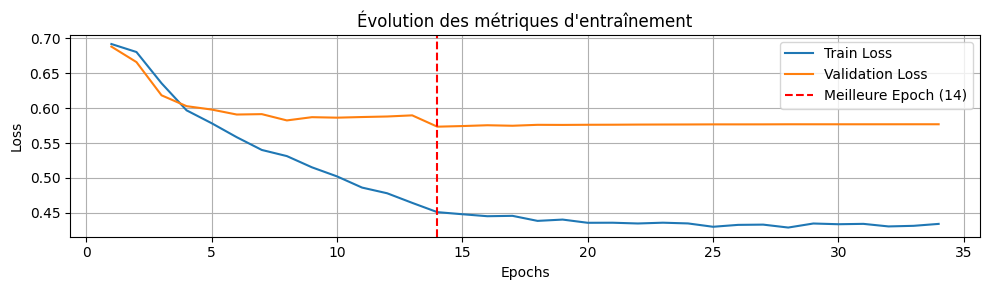

{
    "accuracy": 0.7356060606060606,
    "f1": 0.7401340282948623,
    "recall": 0.753030303030303,
    "confusion_matrix": [
        [
            2370,
            930
        ],
        [
            815,
            2485
        ]
    ],
    "col": "text_preprocess"
}
🏃 View run amusing-fish-36 at: http://localhost:5000/#/experiments/0/runs/75eacad2593448178f876f4cf3bf4b95
🧪 View experiment at: http://localhost:5000/#/experiments/0


Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5149 - loss: 0.6925 - val_accuracy: 0.5791 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5783 - loss: 0.6839 - val_accuracy: 0.6104 - val_loss: 0.6750 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6086 - loss: 0.6716 - val_accuracy: 0.6443 - val_loss: 0.6466 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6496 - loss: 0.6339 - val_accuracy: 0.6617 - val_loss: 0.6111 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6759 - loss: 0.6007 - val_accuracy: 0.6726 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7026 - loss: 0.5838 - val_accuracy: 0.6803 - val_loss: 0.5958 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accu

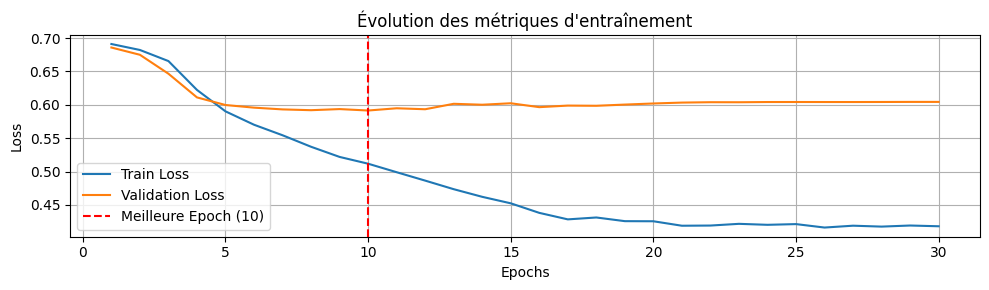

{
    "accuracy": 0.7168181818181818,
    "f1": 0.6948571428571428,
    "recall": 0.6448484848484849,
    "confusion_matrix": [
        [
            2603,
            697
        ],
        [
            1172,
            2128
        ]
    ],
    "col": "text_stemming"
}
🏃 View run upbeat-colt-159 at: http://localhost:5000/#/experiments/0/runs/0f611f5f276345d9ba732832e8052899
🧪 View experiment at: http://localhost:5000/#/experiments/0


Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5108 - loss: 0.6921 - val_accuracy: 0.6047 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5884 - loss: 0.6784 - val_accuracy: 0.6376 - val_loss: 0.6574 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6500 - loss: 0.6385 - val_accuracy: 0.6689 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6918 - loss: 0.5949 - val_accuracy: 0.6786 - val_loss: 0.5970 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7131 - loss: 0.5781 - val_accuracy: 0.6806 - val_loss: 0.5896 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7280 - loss: 0.5588 - val_accuracy: 0.6853 - val_loss: 0.5897 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc

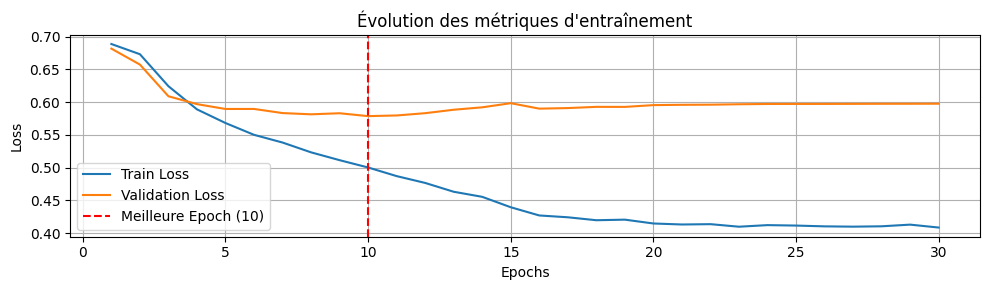

{
    "accuracy": 0.7242424242424242,
    "f1": 0.7107438016528925,
    "recall": 0.6775757575757576,
    "confusion_matrix": [
        [
            2544,
            756
        ],
        [
            1064,
            2236
        ]
    ],
    "col": "text_lemmatize"
}
🏃 View run rebellious-toad-176 at: http://localhost:5000/#/experiments/0/runs/6205f0bc1e834cf5b142ff5754b460bd
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.735606,0.740134,0.753030,"[[2370, 930], [815, 2485]]",text_preprocess,glove,2025-03-01 23:14:47,lstm
1,0.724242,0.710744,0.677576,"[[2544, 756], [1064, 2236]]",text_lemmatize,glove,2025-03-01 23:14:47,lstm
2,0.716818,0.694857,0.644848,"[[2603, 697], [1172, 2128]]",text_stemming,glove,2025-03-01 23:14:47,lstm
3,0.743030,0.750515,0.773030,"[[2353, 947], [749, 2551]]",text_lemmatize,word2vec,2025-03-01 23:12:19,basic neural network
4,0.742727,0.748668,0.766364,"[[2373, 927], [771, 2529]]",text_preprocess,word2vec,2025-03-01 23:12:19,basic neural network
5,0.741515,0.746959,0.763030,"[[2376, 924], [782, 2518]]",text_stemming,word2vec,2025-03-01 23:12:19,basic neural network
6,0.743485,0.750037,0.769697,"[[2367, 933], [760, 2540]]",text_lemmatize,glove,2025-03-01 23:08:46,basic neural network
7,0.740152,0.749525,0.777576,"[[2319, 981], [734, 2566]]",text_stemming,glove,2025-03-01 23:08:46,basic neural network
8,0.735303,0.737569,0.743939,"[[2398, 902], [845, 2455]]",text_preprocess,glove,2025-03-01 23:08:46,basic neural network
9,0.872917,0.860667,0.785000,"[[1153, 47], [258, 942]]",text_preprocess,KerasTokenizer,2025-03-01 23:05:46,svc


In [12]:
metrics = test_nn_model(create_lstm_model, apply_nn_model, nb_rows_per_sentiment=10000, method="glove")
metrics["model_name"] = "lstm"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5256 - loss: 0.6914 - val_accuracy: 0.6102 - val_loss: 0.6829 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6098 - loss: 0.6748 - val_accuracy: 0.6669 - val_loss: 0.6538 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6770 - loss: 0.6322 - val_accuracy: 0.6923 - val_loss: 0.6059 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7163 - loss: 0.5683 - val_accuracy: 0.7214 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7523 - loss: 0.5236 - val_accuracy: 0.7353 - val_loss: 0.5594 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7759 - loss: 0.4879 - val_accuracy: 0.7391 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc

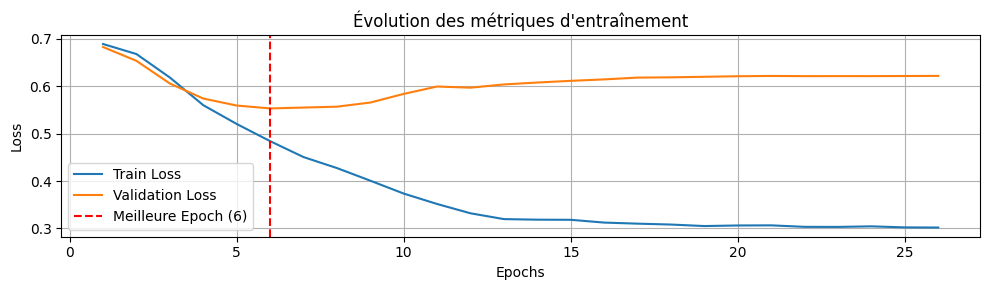

{
    "accuracy": 0.7271212121212122,
    "f1": 0.7095629737139171,
    "recall": 0.6666666666666666,
    "confusion_matrix": [
        [
            2599,
            701
        ],
        [
            1100,
            2200
        ]
    ],
    "col": "text_preprocess"
}
🏃 View run charming-yak-822 at: http://localhost:5000/#/experiments/0/runs/af5e316d2d0e41ec9cb4a5ca2b419a29
🧪 View experiment at: http://localhost:5000/#/experiments/0


Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5453 - loss: 0.6907 - val_accuracy: 0.5771 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6007 - loss: 0.6755 - val_accuracy: 0.6318 - val_loss: 0.6606 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6535 - loss: 0.6457 - val_accuracy: 0.6550 - val_loss: 0.6253 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6921 - loss: 0.5871 - val_accuracy: 0.6903 - val_loss: 0.5861 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7449 - loss: 0.5320 - val_accuracy: 0.7005 - val_loss: 0.5738 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7813 - loss: 0.4894 - val_accuracy: 0.7007 - val_loss: 0.5795 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc

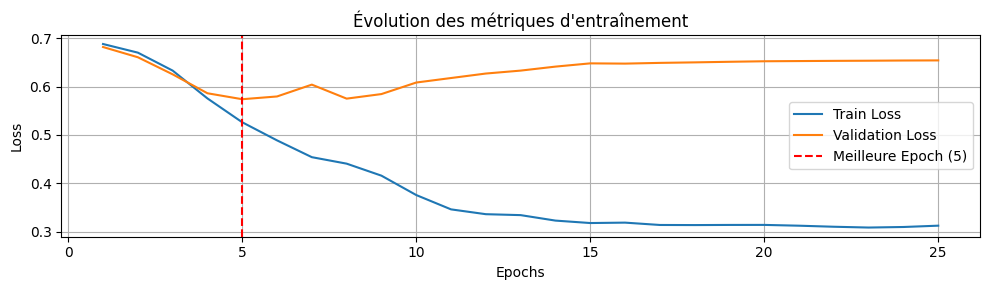

{
    "accuracy": 0.7146969696969697,
    "f1": 0.6933724149161374,
    "recall": 0.6451515151515151,
    "confusion_matrix": [
        [
            2588,
            712
        ],
        [
            1171,
            2129
        ]
    ],
    "col": "text_stemming"
}
🏃 View run selective-bird-142 at: http://localhost:5000/#/experiments/0/runs/88f9555507034d52bf4ac383737bb68a
🧪 View experiment at: http://localhost:5000/#/experiments/0


Epoch 1/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5511 - loss: 0.6898 - val_accuracy: 0.6234 - val_loss: 0.6825 - learning_rate: 1.0000e-04
Epoch 2/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6184 - loss: 0.6762 - val_accuracy: 0.6522 - val_loss: 0.6645 - learning_rate: 1.0000e-04
Epoch 3/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6631 - loss: 0.6480 - val_accuracy: 0.6881 - val_loss: 0.6208 - learning_rate: 1.0000e-04
Epoch 4/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6949 - loss: 0.5898 - val_accuracy: 0.7124 - val_loss: 0.5850 - learning_rate: 1.0000e-04
Epoch 5/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7345 - loss: 0.5451 - val_accuracy: 0.7194 - val_loss: 0.5677 - learning_rate: 1.0000e-04
Epoch 6/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7709 - loss: 0.5079 - val_accuracy: 0.7244 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 7/1000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc

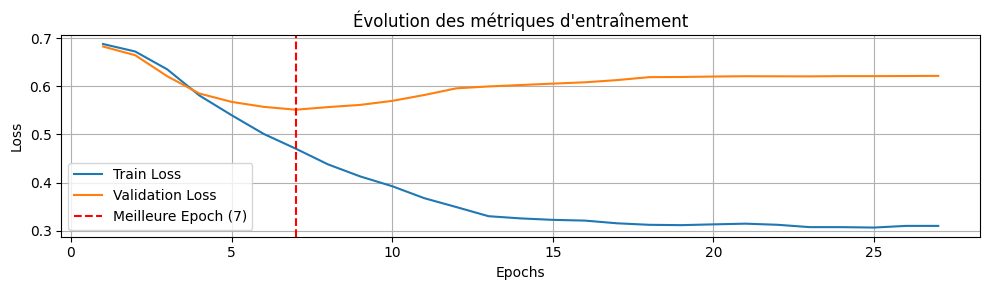

{
    "accuracy": 0.7316666666666667,
    "f1": 0.7150442477876107,
    "recall": 0.6733333333333333,
    "confusion_matrix": [
        [
            2607,
            693
        ],
        [
            1078,
            2222
        ]
    ],
    "col": "text_lemmatize"
}
🏃 View run legendary-cod-158 at: http://localhost:5000/#/experiments/0/runs/a4660184606648db948e20bc3659b3bf
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.731667,0.715044,0.673333,"[[2607, 693], [1078, 2222]]",text_lemmatize,word2vec,2025-03-01 23:17:51,lstm
1,0.727121,0.709563,0.666667,"[[2599, 701], [1100, 2200]]",text_preprocess,word2vec,2025-03-01 23:17:51,lstm
2,0.714697,0.693372,0.645152,"[[2588, 712], [1171, 2129]]",text_stemming,word2vec,2025-03-01 23:17:51,lstm
3,0.735606,0.740134,0.753030,"[[2370, 930], [815, 2485]]",text_preprocess,glove,2025-03-01 23:14:47,lstm
4,0.724242,0.710744,0.677576,"[[2544, 756], [1064, 2236]]",text_lemmatize,glove,2025-03-01 23:14:47,lstm
5,0.716818,0.694857,0.644848,"[[2603, 697], [1172, 2128]]",text_stemming,glove,2025-03-01 23:14:47,lstm
6,0.743030,0.750515,0.773030,"[[2353, 947], [749, 2551]]",text_lemmatize,word2vec,2025-03-01 23:12:19,basic neural network
7,0.742727,0.748668,0.766364,"[[2373, 927], [771, 2529]]",text_preprocess,word2vec,2025-03-01 23:12:19,basic neural network
8,0.741515,0.746959,0.763030,"[[2376, 924], [782, 2518]]",text_stemming,word2vec,2025-03-01 23:12:19,basic neural network
9,0.743485,0.750037,0.769697,"[[2367, 933], [760, 2540]]",text_lemmatize,glove,2025-03-01 23:08:46,basic neural network


In [13]:
metrics = test_nn_model(create_lstm_model, apply_nn_model, nb_rows_per_sentiment=10000, method="word2vec")
metrics["model_name"] = "lstm"
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

## Modèle avancé BERT
- phanerozoic/BERT-Sentiment-Classifier
- nlptown/bert-base-multilingual-uncased-sentiment

In [14]:
def test_hf_models(model_names, nb_rows_per_sentiment=5000):
    df = load_data(nb_rows_per_sentiment=nb_rows_per_sentiment)
    y = df["sentiment"]
    text_cols = [c for c in df.columns if c.startswith("text_")]
    results = []
    for model_name in model_names:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)
        pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
        for col in text_cols:
            with mlflow.start_run() as run:
                X = df[col].values.tolist()
                pred = pipe(X)
                if model_name == 'phanerozoic/BERT-Sentiment-Classifier':
                    pred = [int(p["label"].replace("LABEL_", "")) for p in pred]
                elif model_name == 'nlptown/bert-base-multilingual-uncased-sentiment':
                    pred = [round((int("".join([c for c in p["label"] if c.isnumeric()])) - 1) / 4) for p in pred]
                params = {"col": col, "model_name": model_name}
                metrics = get_metrics(y, pred)
                log_to_mlflow(params=params, metrics=metrics)
                metrics.update(params)
                results.append(metrics)
    df_metrics = pd.DataFrame(results)
    df_metrics = df_metrics.sort_values(by=["f1", "accuracy", "recall"], ascending=[False, False, False]).reset_index(drop=True)
    df_metrics["date"] = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    df_metrics['date'] = pd.to_datetime(df_metrics['date'], format='%Y-%m-%d %H:%M:%S')
    return df_metrics

model_names = [
    'phanerozoic/BERT-Sentiment-Classifier',
    'nlptown/bert-base-multilingual-uncased-sentiment',
]
metrics = test_hf_models(model_names, nb_rows_per_sentiment=10000)
df_metrics = pd.concat([df_metrics, metrics]).sort_values(by=["date", "f1", "accuracy", "recall"], ascending=[False, False, False, False]).reset_index(drop=True)
display(df_metrics)

Device set to use cuda:0


🏃 View run overjoyed-crane-318 at: http://localhost:5000/#/experiments/0/runs/06b944cbbcec447bb5a80f3120917a61
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run sneaky-kite-824 at: http://localhost:5000/#/experiments/0/runs/2190101d2f984efaa6054c98bdc151c2
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run skillful-shrike-187 at: http://localhost:5000/#/experiments/0/runs/6118e1e7665843928d0ee14af77d5d9d
🧪 View experiment at: http://localhost:5000/#/experiments/0


Device set to use cuda:0


🏃 View run lyrical-steed-867 at: http://localhost:5000/#/experiments/0/runs/49aea269eefa44058cb6a0c30a267ac8
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run skittish-kite-578 at: http://localhost:5000/#/experiments/0/runs/7ededaf2114e4701993007cababfae6e
🧪 View experiment at: http://localhost:5000/#/experiments/0
🏃 View run skittish-koi-960 at: http://localhost:5000/#/experiments/0/runs/70c7f6c92dee45b98379b473241e6b63
🧪 View experiment at: http://localhost:5000/#/experiments/0


,accuracy,f1,recall,confusion_matrix,col,method,date,model_name
0,0.662900,0.632629,0.580500,"[[7453, 2547], [4195, 5805]]",text_preprocess,NaN,2025-03-01 23:26:39,nlptown/bert-base-multilingual-uncased-sentiment
1,0.661500,0.630257,0.577000,"[[7460, 2540], [4230, 5770]]",text_lemmatize,NaN,2025-03-01 23:26:39,nlptown/bert-base-multilingual-uncased-sentiment
2,0.639700,0.605756,0.553600,"[[7258, 2742], [4464, 5536]]",text_stemming,NaN,2025-03-01 23:26:39,nlptown/bert-base-multilingual-uncased-sentiment
3,0.637300,0.571884,0.484500,"[[7901, 2099], [5155, 4845]]",text_preprocess,NaN,2025-03-01 23:26:39,phanerozoic/BERT-Sentiment-Classifier
4,0.637450,0.570413,0.481400,"[[7935, 2065], [5186, 4814]]",text_lemmatize,NaN,2025-03-01 23:26:39,phanerozoic/BERT-Sentiment-Classifier
5,0.605200,0.526732,0.439400,"[[7710, 2290], [5606, 4394]]",text_stemming,NaN,2025-03-01 23:26:39,phanerozoic/BERT-Sentiment-Classifier
6,0.731667,0.715044,0.673333,"[[2607, 693], [1078, 2222]]",text_lemmatize,word2vec,2025-03-01 23:17:51,lstm
7,0.727121,0.709563,0.666667,"[[2599, 701], [1100, 2200]]",text_preprocess,word2vec,2025-03-01 23:17:51,lstm
8,0.714697,0.693372,0.645152,"[[2588, 712], [1171, 2129]]",text_stemming,word2vec,2025-03-01 23:17:51,lstm
9,0.735606,0.740134,0.753030,"[[2370, 930], [815, 2485]]",text_preprocess,glove,2025-03-01 23:14:47,lstm


In [15]:
df_metrics.to_csv("metrics.csv", index=False, encoding="utf-8")

# Evaluate metrics

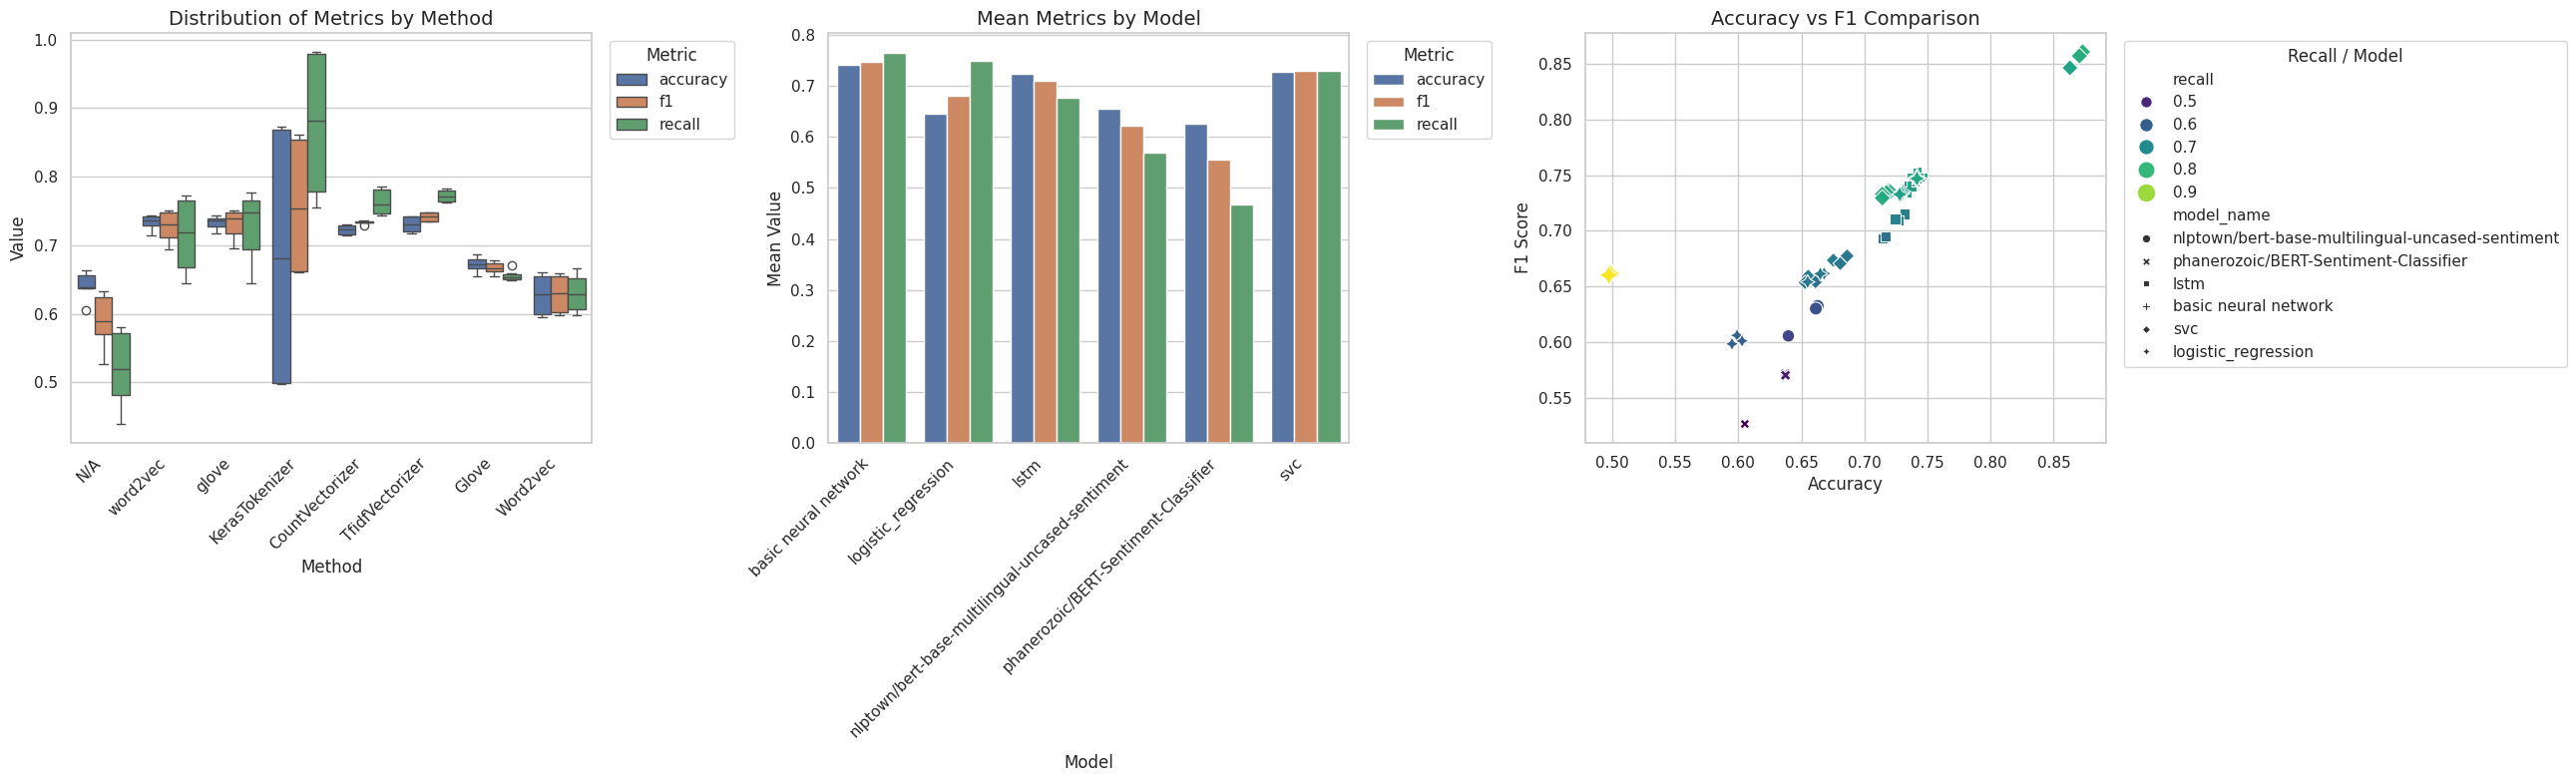

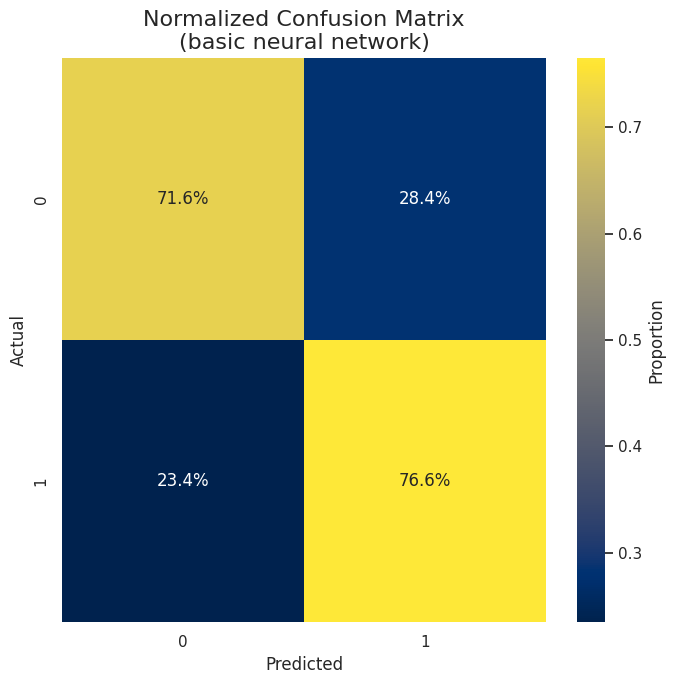

In [21]:
def plot_model_metrics(df):
    """
    Displays several plots to analyze the metrics of binary classification models:
      - Distribution of metrics by method (boxplot)
      - Mean metrics by model (barplot)
      - Scatter plot comparing accuracy and F1, with recall represented by color and size
      - Normalized confusion matrices (in percentage) by model

    If 'df' is a string, it is considered as the path to a CSV file.
    
    Required modules:
      - pandas as pd
      - numpy as np
      - matplotlib.pyplot as plt
      - seaborn as sns
      - ast
    """
    if isinstance(df, str):
        df = pd.read_csv(df, encoding="utf-8")
    else:
        df = df.copy()
    df['method'] = df['method'].fillna("N/A")
    
    def parse_confusion_matrix(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception as e:
                print("Error converting confusion_matrix:", x)
                return None
        return x

    df['confusion_matrix'] = df['confusion_matrix'].apply(parse_confusion_matrix)
    
    def normalize_matrix(matrix):
        matrix = np.array(matrix, dtype=float)
        row_sums = matrix.sum(axis=1, keepdims=True)
        return np.divide(matrix, row_sums, out=np.zeros_like(matrix), where=row_sums != 0)
    sns.set(style="whitegrid", palette="deep")
    
    fig, axs = plt.subplots(1, 3, figsize=(26, 8))
    metrics = ['accuracy', 'f1', 'recall']
    df_long = df.melt(id_vars=['method', 'model_name'], value_vars=metrics, 
                      var_name='metric', value_name='value')
    sns.boxplot(data=df_long, x='method', y='value', hue='metric', ax=axs[0])
    axs[0].set_title("Distribution of Metrics by Method", fontsize=14)
    axs[0].set_xlabel("Method", fontsize=12)
    axs[0].set_ylabel("Value", fontsize=12)
    plt.setp(axs[0].get_xticklabels(), rotation=45, ha='right')
    axs[0].legend(title="Metric", loc='upper left', bbox_to_anchor=(1.02, 1))

    avg_metrics = df.groupby('model_name')[metrics].mean().reset_index()
    avg_long = avg_metrics.melt(id_vars='model_name', var_name='metric', value_name='value')
    sns.barplot(data=avg_long, x='model_name', y='value', hue='metric', ax=axs[1])
    axs[1].set_title("Mean Metrics by Model", fontsize=14)
    axs[1].set_xlabel("Model", fontsize=12, labelpad=10)
    axs[1].set_ylabel("Mean Value", fontsize=12)
    plt.setp(axs[1].get_xticklabels(), rotation=45, ha='right')
    axs[1].legend(title="Metric", loc='upper left', bbox_to_anchor=(1.02, 1))

    sns.scatterplot(data=df, x='accuracy', y='f1', hue='recall', style='model_name', 
                    size='recall', sizes=(50, 200), palette="viridis", ax=axs[2])
    axs[2].set_title("Accuracy vs F1 Comparison", fontsize=14)
    axs[2].set_xlabel("Accuracy", fontsize=12)
    axs[2].set_ylabel("F1 Score", fontsize=12)
    axs[2].legend(title="Recall / Model", loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.tight_layout()
    plt.show()

    models = df['model_name'].unique()

    def get_normalized_confusion_matrix(df_model):
        matrices = df_model['confusion_matrix'].dropna().apply(lambda x: np.array(x, dtype=float))
        if matrices.empty:
            return None
        total_matrix = np.sum(list(matrices), axis=0)
        return normalize_matrix(total_matrix)

    cmap_heat = "cividis"

    if len(models) <= 4:
        n_models = len(models)
        fig_cm, axes = plt.subplots(1, n_models, figsize=(7 * n_models, 7))
        if n_models == 1:
            axes = [axes]
        for ax, model in zip(axes, models):
            df_model = df[df['model_name'] == model]
            norm_matrix = get_normalized_confusion_matrix(df_model)
            if norm_matrix is None:
                continue
            annot = np.vectorize(lambda x: f"{x*100:.1f}%")(norm_matrix)
            sns.heatmap(norm_matrix, annot=annot, fmt="", cmap=cmap_heat, ax=ax,
                        cbar_kws={'label': 'Proportion'}, annot_kws={"fontsize": 12})
            ax.set_title(f"Confusion Matrix\n({model})", fontsize=14)
            ax.set_xlabel("Predicted", fontsize=12)
            ax.set_ylabel("Actual", fontsize=12)
        fig_cm.suptitle("Normalized Confusion Matrices by Model", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        best_model = df.groupby('model_name')['accuracy'].mean().idxmax()
        df_best = df[df['model_name'] == best_model]
        norm_matrix = get_normalized_confusion_matrix(df_best)
        if norm_matrix is not None:
            annot = np.vectorize(lambda x: f"{x*100:.1f}%")(norm_matrix)
            plt.figure(figsize=(7, 7))
            sns.heatmap(norm_matrix, annot=annot, fmt="", cmap=cmap_heat,
                        cbar_kws={'label': 'Proportion'}, annot_kws={"fontsize": 12})
            plt.title(f"Normalized Confusion Matrix\n({best_model})", fontsize=16)
            plt.xlabel("Predicted", fontsize=12)
            plt.ylabel("Actual", fontsize=12)
            plt.tight_layout()
            plt.show()


plot_model_metrics("metrics.csv")

# Train Final model for API
https://colab.research.google.com/drive/1lMPRu-IUyLK5MNLYt5TyOcQdd9MMHHKW?usp=sharing

In [ ]:
model_path = 'sentiment_model.p'
encoder_path = 'sentiment_encoder.pk'
param_grid = {
    "C": [1.0, 1.5, 2.0],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "tol": [1e-3, 1e-2, 1e-4],
}
df = load_data(nb_rows_per_sentiment=8000)
X = df["text_stemming"].values
y = df["sentiment"].values.tolist()
encoder = TfidfVectorizer()
X = encoder.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y, shuffle=True)

with mlflow.start_run() as run:
            metrics["col"] = col
            print(json.dumps(metrics, indent=4))
            metrics.update(hyperparams)
            results.append(metrics)
    model = SVC()
    # grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3, verbose=2)
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1', cv=3, verbose=2, n_iter=10)
    timer = time.time()
    grid_search.fit(X_train, y_train)
    print("fit timer:", round(time.time() - timer, 2), "sec")
    model = grid_search.best_estimator_
    params = grid_search.best_params_
    y_pred = model.predict(X_test)
    metrics = get_metrics(y_test, y_pred)
    log_to_mlflow(metrics=metrics)
    mlflow.sklearn.log_model(model, artifact_path="model")
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    with open(encoder_path, 'wb') as f:
        pickle.dump(encoder, f)
    print(json.dumps(params, indent=4))
    print(json.dumps(metrics, indent=4))

In [ ]:
def prepro_text(text,
                stop_words=None,
                remove_html=True,
                remove_accents=True,
                lower=True,
                replace_html=True,
                replace_hashtag=True,
                remove_stopwords=True,
                remove_punct=True,
                stemming=False,
                stemming_ps=None):
    if stop_words is None:
        stop_words = nltk_stopwords.words('english')
        stop_words = list(set(stop_words))
        stop_words.sort()
    if remove_html:
        text = BeautifulSoup(text).text
    if remove_accents:
        text = unidecode(text)
    if lower:
        text = text.lower()
    if replace_hashtag:
        text = text.replace("#", " hashtag ")
    if remove_punct:
        text = text.translate(str.maketrans("", "", string.punctuation))
    if remove_stopwords:
        tokens = word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stop_words]
        text = " ".join(tokens)
    text = " ".join(text.split())
    if stemming:
        if stemming_ps is None:
            raise ValueError("Need stemming ps argument.")
        tokens = word_tokenize(text)
        stem_tokens = [stemming_ps.stem(t) for t in tokens]
        text = " ".join(stem_tokens)
    return text


def pred_text(text, encoder, model, stemming_ps, stop_words, stemming=True):
    text = prepro_text(text, stop_words=stop_words, stemming=stemming, stemming_ps=stemming_ps)
    tokens = encoder.transform([text])
    pred = model.predict(tokens)[0]
    return pred


# Load stuff
model_path = 'sentiment_model.p'
encoder_path = 'sentiment_encoder.pk'
model = pickle.load(open(model_path, 'rb'))
encoder = pickle.load(open(encoder_path, 'rb'))
stemming_ps = PorterStemmer()
stop_words = nltk_stopwords.words('english')
stop_words = list(set(stop_words))
stop_words.sort()

# test
pred_text("This is a test !!! I hate chocolate very much", encoder, model, stemming_ps, stop_words)